In [1]:
import torchvision
from torchvision import models
from torchvision.transforms import transforms
from tqdm import tqdm
import torch
import ImageData
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time

In [2]:
model_name = "resnet"
model_image_size = 224
# vit = models.vit_l_16(models.ViT_L_16_Weights.IMAGENET1K_V1)

In [3]:
class ResNet(torch.nn.Module):
    def __init__(self, numClasses: int, softmax:bool = True):
        super(ResNet, self).__init__()

        self.resnet = torchvision.models.resnet152(weights='DEFAULT')
        for param in list(self.resnet.parameters())[:-1]:
            param.requires_grad = False

        self.resnet.fc = torch.nn.Sequential(
            torch.nn.Linear(2048, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 216),
            torch.nn.ReLU(),
            torch.nn.Linear(216, 4)
        )
        
        
        # for param in self.inceptionBase.parameters():
        #     print(param.requires_grad)

        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        out = self.resnet(x)
        return out

In [4]:
model = ResNet(4).to(device)
# print(*list(model.children())[:-1])

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to C:\Users\wiggle_jiggle/.cache\torch\hub\checkpoints\resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:07<00:00, 31.8MB/s] 


In [5]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
batch_size = 16
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.RandomResizedCrop(size=(model_image_size, model_image_size), antialias=True), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainDataLoader, validDataLoader, testDataLoader, unseenDataLoader = ImageData.getImagesDataloaders("./ArtiFact/", transforms = transform, batchSize=batch_size)

In [17]:
def evaluate_on_data(model, dataloader, dirty: bool = False):
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        total_loss = 0
        
        num_correct = 0.0
        num_correct_dirty = 0.0

        num_samples = 0.0
        for data in tqdm(dataloader, desc="Eval: "):
            image, label = data
            label = label.to(device)
            image = image.to(device)
            outputs = model(image)
            
            dirtyLabel = torch.where(label > 1, torch.tensor(1, dtype = torch.int32).to(device), label)

            
            
            loss = criterion(outputs, label)
            total_loss += loss.item()
            argMax = torch.argmax(outputs, 1)

            # print("pred")
            # print(outputs)
            # print(argMax)
            # print("gt")
            # print(label)
            for i in range(len(label)):
                
                if label[i] == argMax[i]:
                    num_correct += 1

                if (dirtyLabel[i] == argMax[i]) or (dirtyLabel[i] == 1 and argMax[i] > 0):
                    num_correct_dirty += 1

                num_samples += 1
                    
                
                
    return total_loss / len(dataloader), num_correct / num_samples, num_correct_dirty / num_samples

In [8]:
num_epochs = 10
count = 0
valid_loss_array = np.zeros(num_epochs)
valid_acc_array = np.zeros(num_epochs)
valid_acc_dirty_array = np.zeros(num_epochs)

train_loss_array = np.zeros(num_epochs)
for epoch in range(num_epochs):
    batch_count = 0
    for data in tqdm(trainDataLoader, desc="Training: "):
        
        image, label = data
        
        label = label.to(device)
        image = image.to(device)

        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
          
        count += 1
        # print(loss)
            
        
    valid_loss, valid_acc = evaluate_on_data(model, validDataLoader)
    _, valid_acc_dirty = evaluate_on_data(model, validDataLoader, dirty=True)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Valid Loss: {valid_loss}, Valid ACC: {valid_acc}, Dirty Valid ACC: {valid_acc_dirty}')
    valid_loss_array[epoch] = valid_loss
    train_loss_array[epoch] = loss.item()
    valid_acc_array[epoch] = valid_acc
    valid_acc_dirty_array[epoch] = valid_acc_dirty


Training:   0%|          | 0/116172 [00:00<?, ?it/s]

Eval: 100%|██████████| 6115/6115 [03:26<00:00, 29.62it/s]


Epoch [1/10], Training Loss: 0.9489, Valid Loss: 0.6765317808504682, Valid ACC: 0.7185263932616429, Dirty Valid ACC: 0.7052173201946274


Eval: 100%|██████████| 6115/6115 [03:26<00:00, 29.62it/s]


Epoch [2/10], Training Loss: 0.7470, Valid Loss: 0.662142679343824, Valid ACC: 0.7268573414564338, Dirty Valid ACC: 0.7194770413378583


Eval: 100%|██████████| 6115/6115 [03:31<00:00, 28.89it/s]


Epoch [3/10], Training Loss: 0.3358, Valid Loss: 0.6522315822267571, Valid ACC: 0.7332461054094942, Dirty Valid ACC: 0.7278795436889234


Eval: 100%|██████████| 6115/6115 [03:28<00:00, 29.29it/s]


Epoch [4/10], Training Loss: 0.9662, Valid Loss: 0.6478577030431221, Valid ACC: 0.7352598438074989, Dirty Valid ACC: 0.715551784765098


Eval: 100%|██████████| 6115/6115 [03:13<00:00, 31.57it/s]


Epoch [5/10], Training Loss: 0.9443, Valid Loss: 0.6430831384190944, Valid ACC: 0.7363024900846383, Dirty Valid ACC: 0.7192930449360101


Eval: 100%|██████████| 6115/6115 [03:16<00:00, 31.12it/s]


Epoch [6/10], Training Loss: 0.4386, Valid Loss: 0.6474893369322806, Valid ACC: 0.7408615120415423, Dirty Valid ACC: 0.7138344850145153


Eval: 100%|██████████| 6115/6115 [03:31<00:00, 28.92it/s]


Epoch [7/10], Training Loss: 0.7373, Valid Loss: 0.6378197729148927, Valid ACC: 0.7404526311485464, Dirty Valid ACC: 0.721787218383285


Eval: 100%|██████████| 6115/6115 [03:17<00:00, 31.03it/s]


Epoch [8/10], Training Loss: 0.9743, Valid Loss: 0.630311694749778, Valid ACC: 0.7439996728952856, Dirty Valid ACC: 0.7205503536819724


Eval: 100%|██████████| 6115/6115 [03:27<00:00, 29.41it/s]


Epoch [9/10], Training Loss: 1.8805, Valid Loss: 0.6295555192139533, Valid ACC: 0.7455636423109948, Dirty Valid ACC: 0.7205503536819724


Eval: 100%|██████████| 6115/6115 [03:07<00:00, 32.57it/s]

Epoch [10/10], Training Loss: 1.5347, Valid Loss: 0.6318216321123299, Valid ACC: 0.7433761295334669, Dirty Valid ACC: 0.7231876354417958


In [9]:
with open(model_name + '_valid_loss.npy', 'wb') as f:
    np.save(f, valid_loss_array)
    
with open(model_name + '_valid_acc.npy', 'wb') as f:
    np.save(f, valid_acc_array)

with open(model_name + '_valid_dirty_acc.npy', 'wb') as f:
    np.save(f, valid_acc_dirty_array)
    
with open(model_name + '_train.npy', 'wb') as f:
    np.save(f, train_loss_array)

In [10]:
import matplotlib.pyplot as plt

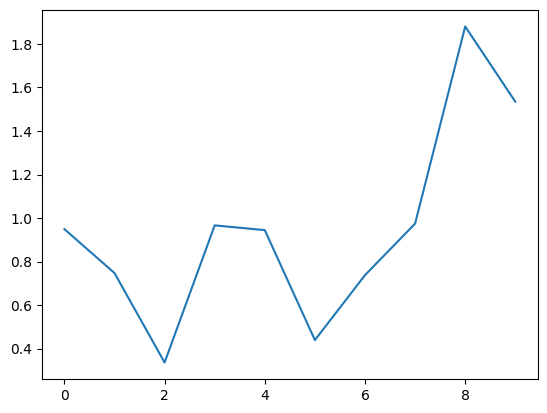

In [11]:
plt.plot(train_loss_array)

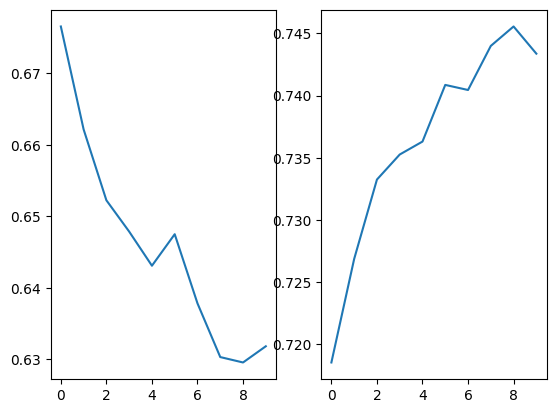

In [13]:
figure, axis = plt.subplots(1,2)
axis[0].plot(valid_loss_array)
axis[1].plot(valid_acc_dirty_array)

In [19]:
_,_, valid_acc_dirty = evaluate_on_data(model, validDataLoader, dirty=True)
valid_acc_dirty

Eval: 100%|██████████| 6115/6115 [06:54<00:00, 14.74it/s]


0.7848877621948727

In [20]:
test_loss, test_acc, test_acc_dirty = evaluate_on_data(model, testDataLoader, dirty=True)
print(f'Test Loss: {test_loss}, Test ACC: {test_acc}, Dirty Test ACC: {test_acc_dirty}')

Eval: 100%|██████████| 33761/33761 [1:34:05<00:00,  5.98it/s]

Test Loss: 0.7041640547670102, Test ACC: 0.7057603874321512, Dirty Test ACC: 0.7488762838503291


In [24]:
unseen_loss, unseen_acc, unseen_acc_dirty = evaluate_on_data(model, unseenDataLoader, dirty=True)
print(f'Unseen Loss: {unseen_loss}, Unseen ACC: {unseen_acc}, Dirty Unseen ACC: {unseen_acc_dirty}')

Eval: 100%|██████████| 1569/1569 [00:53<00:00, 29.32it/s]

Unseen Loss: 1.6271382283070348, Unseen ACC: 0.3303315269365636, Dirty Unseen ACC: 0.5115157794070768
